# Naive Bayes Classifier

Naive bayes suppose that features are event conditionally independent given y (real target), i.e:

$$P(x_1,...,x_n|y) = \prod^{n}_{i=1} P(x_i|n)$$

For numerical stability working with probabilities we are going to use logprob:
$$\pi_i = log(p_i)$$
Then, product of probabilities will be the sum:
$$\prod^{n}_{i=1}p_i \rightarrow \sum\log{p_i} = \sum\pi_i$$

## Imports

In [97]:
%matplotlib widget
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchvision

import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Download data mnist

In [62]:
class custom_transform(object):
    def __call__(self, sample):
        image = sample.data
        return torch.floor(image.float()/128)

In [63]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [64]:
mnist_train = torchvision.datasets.MNIST(root='./data', download=True, transform=transform, train=True)
mnist_test = torchvision.datasets.MNIST(root='./data', download=True, transform=transform, train=False)

In [65]:
c_trt = custom_transform()
mnist_train.data = c_trt(mnist_train)
mnist_test.data = c_trt(mnist_test)

## Visualize some images

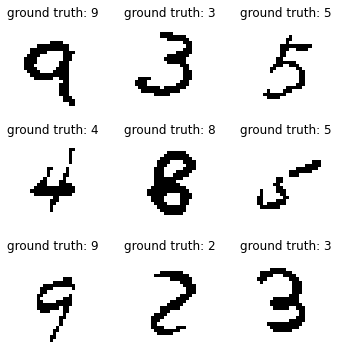

In [66]:
%matplotlib inline
import random

num_rows = 3
num_cols = 3
num_images = num_rows*num_cols 
pick_random = random.choices(range(mnist_train.data.shape[0]), k=num_images)
fig = plt.figure(figsize=(5, 5))

for idx_plot, idx_random in enumerate(pick_random):
    plt.subplot(num_rows, num_cols, idx_plot + 1)
    plt.imshow(mnist_train.data[idx_random].view(28, 28), cmap='gray_r')
    plt.axis('off')
    plt.title("ground truth: {}".format(mnist_train.targets[idx_random]))
plt.tight_layout()
plt.show()

## Modeling Naive Bayes

Bayes theorem state that:

$$P(y|x) = \frac{P(x|y)P(y)}{P(x)}$$

Since $P(x)$ is constant for a given input, because it does not depend on $y$, we can use the following classification rule:

\begin{align}
    \begin{aligned}
        P(y \mid x) \propto P(y) P(x \mid y)
        \\\Downarrow\\\
        \hat{y} = \arg\max_y P(y) P(x \mid y),
    \end{aligned}
\end{align}
Being the last one the maximum posteriori (MAP) decision rule.

In our case $P(y)$ is the probability of being a especific numbers. We can get this probability as follows:

$P(y_i) = \frac{n(y_i)}{n(y)}$ then the $P(y) = [P(y_1), ..., P(y_n)]$

### Getting $P(y)$ and visualize probability distribution

In [67]:
y_unique, y_counts = mnist_train.targets.unique(return_counts=True)

In [68]:
py = y_counts.float()/y_counts.sum()

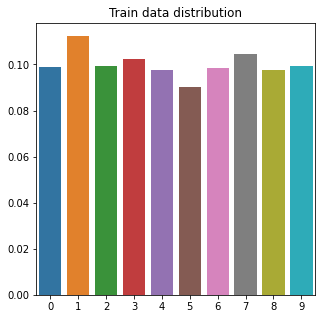

In [69]:
import seaborn as sbn

plt.figure(figsize=(5,5))
sbn.barplot(x=list(range(10)), y=py)
plt.title("Train data distribution")
plt.show()

### Getting $P(x\mid y)$

Where $P(x_1, ..., x_n| y)$, each $x_1,...,x_n$ is a pixel feature in the image, since Naive Bayes suppose that each feature is conditional independent to $y$ then:

$$P(x_1,...,x_n|y) = \prod^{n}_{i=1}P(x_i|y)$$

Then we need to calculate $P(x_i|y)$

`px` is the mean of all feature in each class, $$px[j] = \frac{\sum_{i=1:y=y_j}^{n} x_i}{n(y_j)}$$

In [70]:
x_counts = torch.zeros(size=(28*28, 10), dtype=torch.float)
for digit in range(10):
    images_digit = mnist_train.data[mnist_train.targets == digit].float().view(-1,28*28)
    x_counts[:,digit] = 1 + images_digit.sum(dim=0)
px = (x_counts/y_counts.view(-1, 10)) #the sum of all image (specif digit) / the quantity of image of that digit

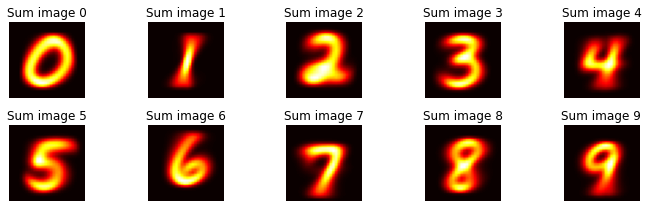

In [71]:
fig = plt.figure(figsize=(10,3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_counts[:,i].view(28, 28), cmap='hot')
    plt.title("Sum image {}".format(i))
    plt.axis('off')
plt.tight_layout()
plt.show()

### Normalization (with log for numerical stability) 

In [72]:
logpx = torch.log(px)
logpxneg = torch.log(1-px)
logpy = torch.log(py)

def bayes_posteriori(data):
    """
    Get bayes posterior probability given data, using logsum for
    numerical stability with probabilities.
    
        p(y|data) is proportional to p(y)p(data|y)
        p(y) is the apriori probability
        p(y|data) is the posteriori probability
    
    Args:
        data -- digit image shape (-1, 1)
    """
    logpost = logpy.clone()
    logpost += (logpx*data + logpxneg * (1-data)).sum(dim=0)
    logpost -= torch.max(logpost)
    # Recover probabilities using the invers of log -> exp
    post = torch.exp(logpost)
    post /= torch.sum(post) # Normalize
    return post

### Visualize predictions

In [106]:
def plot_image(posteriori_probs, true_label, img):
    
    predicted_label = torch.argmax(posteriori_probs).item()
    
    color_selected = lambda x, y: 'blue' if x == y else 'red'
    
    color = color_selected(true_label.item(), predicted_label)
    
    
    plt.imshow(img.view(28,28), cmap='hot')
    plt.xlabel("p:{} {:5.0f}% (r:{})".format(predicted_label, 
                                        100*torch.max(posteriori_probs).item(),
                                        true_label.item()),color=color)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

In [122]:
def plot_bar_probs(posteriori_probs, true_label):
    bar_plot = plt.bar(range(10), posteriori_probs, color="#777777")
    predicted_label = torch.argmax(posteriori_probs).item()
    
    bar_plot[predicted_label].set_color('red')
    bar_plot[true_label.item()].set_color('blue')
    
    plt.ylim([0,1])
    plt.xticks(range(10))
    plt.yticks([])
    plt.grid(False)

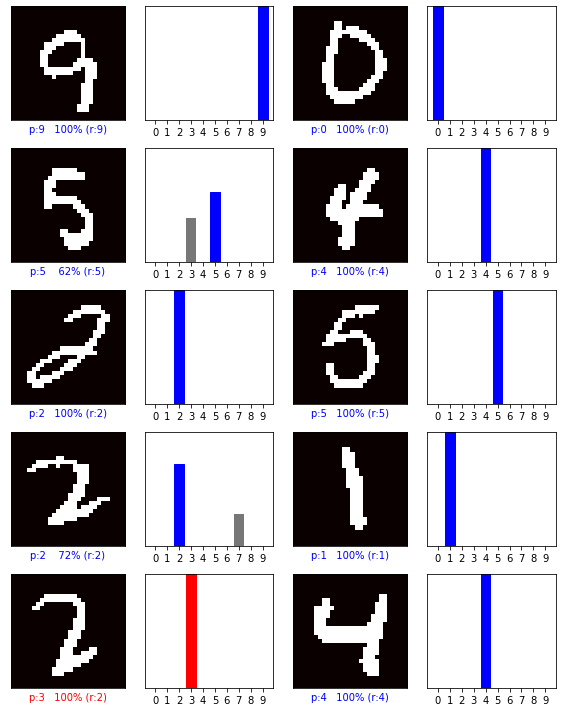

In [145]:
%matplotlib inline

num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
fig = plt.figure(figsize=(2*2*num_cols, 2*num_rows))
random_pick = random.choices(range(mnist_test.data.shape[0]), k=num_images)

for idx_plot, idx_image in enumerate(random_pick):
    img = mnist_test.data[idx_image]
    true_label = mnist_test.targets[idx_image]
    posteriori_probs = bayes_posteriori(img.view(-1,1))
    
    plt.subplot(num_rows, 2*num_cols, 2*idx_plot + 1)
    plot_image(posteriori_probs, true_label, img)
    
    plt.subplot(num_rows, 2*num_cols, 2*idx_plot+2)
    plot_bar_probs(posteriori_probs, true_label)

plt.tight_layout()
plt.show()

### Compute accuracy

In [144]:
# initialize counter
ctr = 0
err = 0

for data, label in tqdm(zip(mnist_test.data, mnist_test.targets),
                       total=mnist_test.data.shape[0]):
    ctr += 1
    x = data.view((784,1))
    y = int(label)

    post = bayes_posteriori(x)
    if (post[y] < post.max()):
        err += 1

print('Naive Bayes has an error rate of', err/ctr)
print('Naive Bayes accuracy rate of', 1 - err/ctr)


Naive Bayes has an error rate of 0.1574
Naive Bayes accuracy rate of 0.8426
